## FAST UNIVARIATE TIME-SERIES CLASSIFICATION

This notebook explores the classification of univariate time-series data by three methods:
- Via Tabularization + RandomForest
- Via Feature Extraction + RandomForest
- Direct univariate + ROCKET

### Dependencies and Methods

In [16]:
!pip install sktime --quiet
!pip install sktime[all_extras] --quiet
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 5.2 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from warnings import simplefilter
from pandas.core.common import random_state
import matplotlib.pyplot as plt

from sktime.transformations.panel.rocket import MiniRocket, MiniRocketMultivariate
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
from sktime.datatypes._panel._convert import from_nested_to_2d_array

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier  # get a baseline for comparison

ERROR:numba.cuda.cudadrv.driver:Call to cuInit results in CUDA_ERROR_NO_DEVICE


In [2]:
def str2listf(l):
    l = l.replace("[", "")
    l = l.replace("]", "")
    l = l.replace("\n", "")
    l = l.split(', ')
    l = [float(i) for i in l]
    return l


def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True User')
  plt.xlabel('Predicted User')

### Data and Pre-processing

In [50]:
df = pd.read_csv('arup_normal_binary.csv')
df.head()

,Unnamed: 0,pupil_dilation,baseline,rating
0,0,"[-0.9014, -0.859, -0.8329, -0.8297, -0.8295, -...","[3.41, 2.6965, 2.6374, 2.6537, 2.4541, 2.1852,...",1
1,1,"[-1.2559, -1.063, -1.0623, -0.7683, -0.7615, -...","[1.0139, 1.0101, 1.0456, 1.0916, 1.124, 1.1476...",1
2,2,"[-0.4935, -0.6439, -0.7684, -0.8749, -0.915, -...","[-1.6341, -1.6341, -1.4857, -1.3273, -1.2686, ...",1
3,3,"[-1.0812, -1.1477, -1.2715, -1.4091, -1.4491, ...","[1.4851, 1.4257, 1.4206, 1.3109, 1.24, 1.2362,...",0
4,4,"[-2.5562, -2.607, -2.6038, -2.6388, -2.6514, -...","[0.5212, 0.4968, 0.494, 0.5471, 0.5463, 0.5154...",1


In [51]:
# GLOBAL PRE-PROCESSING

df.index = df['Unnamed: 0'].tolist()
del df['Unnamed: 0']

df.pupil_dilation = df.pupil_dilation.apply(str2listf)
df.baseline = df.baseline.apply(str2listf)
df['rating'] = df['rating'].apply(lambda i: int(i))
df

,pupil_dilation,baseline,rating
0,"[-0.9014, -0.859, -0.8329, -0.8297, -0.8295, -...","[3.41, 2.6965, 2.6374, 2.6537, 2.4541, 2.1852,...",1
1,"[-1.2559, -1.063, -1.0623, -0.7683, -0.7615, -...","[1.0139, 1.0101, 1.0456, 1.0916, 1.124, 1.1476...",1
2,"[-0.4935, -0.6439, -0.7684, -0.8749, -0.915, -...","[-1.6341, -1.6341, -1.4857, -1.3273, -1.2686, ...",1
3,"[-1.0812, -1.1477, -1.2715, -1.4091, -1.4491, ...","[1.4851, 1.4257, 1.4206, 1.3109, 1.24, 1.2362,...",0
4,"[-2.5562, -2.607, -2.6038, -2.6388, -2.6514, -...","[0.5212, 0.4968, 0.494, 0.5471, 0.5463, 0.5154...",1
...,...,...,...
475,"[-0.4229, -0.3993, -0.4078, -0.368, -0.3401, -...","[-5.0088, -2.2285, 0.8714, 1.1674, 1.1761, 1.1...",0
476,"[-0.968, -0.9316, -0.9057, -0.8822, -0.8318, -...","[1.6413, 1.6413, 1.3714, 1.0433, 1.0318, 0.944...",0
477,"[-1.0654, -1.0005, -0.9954, -0.9871, -0.9423, ...","[1.7101, 1.7101, 1.6823, 1.5451, 1.5709, 1.628...",0
478,"[-0.3034, -0.2804, -0.2725, -0.2404, -0.0864, ...","[1.3916, 0.9135, 0.7914, 0.7914, 0.6765, 0.676...",0


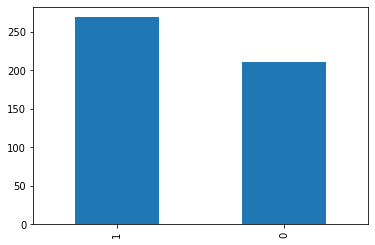

In [52]:
df.rating.value_counts().plot(kind="bar")

In [53]:
# Univariate 1 (join baseline to pupil_dilation)
# binary rule : # df_alt['rating'] = df['rating'].apply(lambda i: 0 if i<3 else 1)

# df_alt = df.copy(deep=True)

# df_alt.rating = df_alt.rating.astype(str)
# df_alt['pupil_dilation'] = [b + p for b, p in zip(df_alt['baseline'], df_alt['pupil_dilation'])]
# del df_alt['baseline']
# df_alt

In [54]:
# Univariate 2
df_alt = df.copy(deep=True)
df_alt.rating = df_alt.rating.astype(str)
del df_alt['baseline']
df_alt

,pupil_dilation,rating
0,"[-0.9014, -0.859, -0.8329, -0.8297, -0.8295, -...",1
1,"[-1.2559, -1.063, -1.0623, -0.7683, -0.7615, -...",1
2,"[-0.4935, -0.6439, -0.7684, -0.8749, -0.915, -...",1
3,"[-1.0812, -1.1477, -1.2715, -1.4091, -1.4491, ...",0
4,"[-2.5562, -2.607, -2.6038, -2.6388, -2.6514, -...",1
...,...,...
475,"[-0.4229, -0.3993, -0.4078, -0.368, -0.3401, -...",0
476,"[-0.968, -0.9316, -0.9057, -0.8822, -0.8318, -...",0
477,"[-1.0654, -1.0005, -0.9954, -0.9871, -0.9423, ...",0
478,"[-0.3034, -0.2804, -0.2725, -0.2404, -0.0864, ...",0


In [55]:
print(df_alt['pupil_dilation'].dtype)
df_alt['pupil_dilation'].shape

object


(480,)

In [56]:
X = df_alt[['pupil_dilation']]
y = df_alt[['rating']]
print(X.shape, y.shape)
print(X['pupil_dilation'].dtype)
X

(480, 1) (480, 1)
object


,pupil_dilation
0,"[-0.9014, -0.859, -0.8329, -0.8297, -0.8295, -..."
1,"[-1.2559, -1.063, -1.0623, -0.7683, -0.7615, -..."
2,"[-0.4935, -0.6439, -0.7684, -0.8749, -0.915, -..."
3,"[-1.0812, -1.1477, -1.2715, -1.4091, -1.4491, ..."
4,"[-2.5562, -2.607, -2.6038, -2.6388, -2.6514, -..."
...,...
475,"[-0.4229, -0.3993, -0.4078, -0.368, -0.3401, -..."
476,"[-0.968, -0.9316, -0.9057, -0.8822, -0.8318, -..."
477,"[-1.0654, -1.0005, -0.9954, -0.9871, -0.9423, ..."
478,"[-0.3034, -0.2804, -0.2725, -0.2404, -0.0864, ..."


In [57]:
y

,rating
0,1
1,1
2,1
3,0
4,1
...,...
475,0
476,0
477,0
478,0


In [58]:
X = X.applymap(lambda s: pd.Series(s))
print(X.shape, y.shape)
print(X['pupil_dilation'].dtype)
X

(480, 1) (480, 1)
object


,pupil_dilation
0,0 -0.9014 1 -0.8590 2 -0.8329 3 ...
1,0 -1.2559 1 -1.0630 2 -1.0623 3 ...
2,0 -0.4935 1 -0.6439 2 -0.7684 3 ...
3,0 -1.0812 1 -1.1477 2 -1.2715 3 ...
4,0 -2.5562 1 -2.6070 2 -2.6038 3 ...
...,...
475,0 -0.4229 1 -0.3993 2 -0.4078 3 ...
476,0 -0.9680 1 -0.9316 2 -0.9057 3 ...
477,0 -1.0654 1 -1.0005 2 -0.9954 3 ...
478,0 -0.3034 1 -0.2804 2 -0.2725 3 ...


In [59]:
df_alt = pd.concat([X, y], axis=1)
df_alt.to_csv("tklearn_ready.csv")

### Classifiers

#### Tabularization

number of samples per class:  211

tuning model...
(data is shuffled)

_____________________________________________________________________

fold:  1
['0' '1'] [168 169]
displaying first {n_display} samples for each class


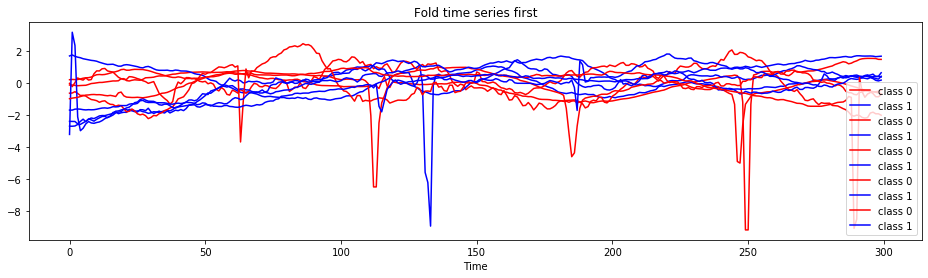

Dummy score:  0.49411764705882355
random forest score:  0.5294117647058824

0. xtrain (337, 1)
1. ytrain
 (337,)

fold:  2
['0' '1'] [169 168]
displaying first {n_display} samples for each class


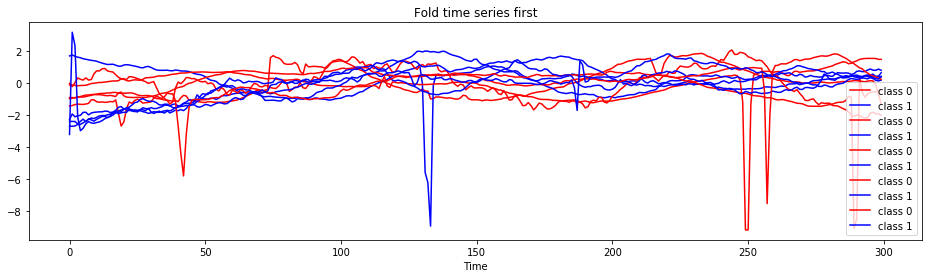

Dummy score:  0.49411764705882355
random forest score:  0.5882352941176471

0. xtrain (337, 1)
1. ytrain
 (337,)

fold:  3
['0' '1'] [169 169]
displaying first {n_display} samples for each class


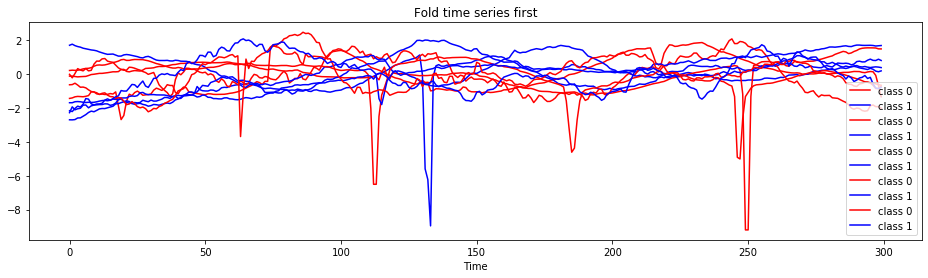

Dummy score:  0.5
random forest score:  0.5833333333333334

0. xtrain (338, 1)
1. ytrain
 (338,)

fold:  4
['0' '1'] [169 169]
displaying first {n_display} samples for each class


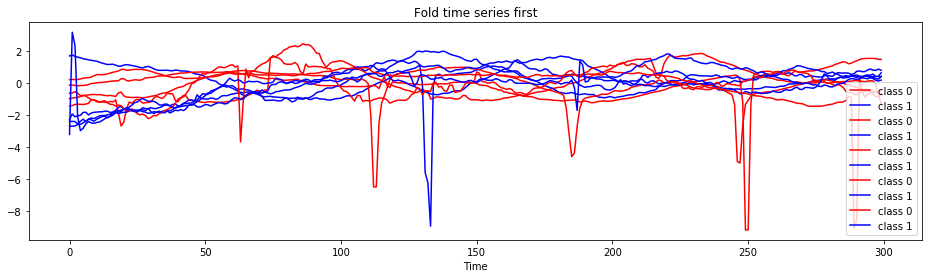

Dummy score:  0.5
random forest score:  0.5833333333333334

0. xtrain (338, 1)
1. ytrain
 (338,)

fold:  5
['0' '1'] [169 169]
displaying first {n_display} samples for each class


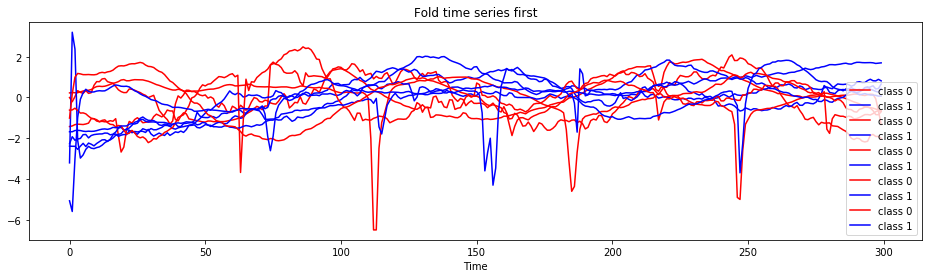

Dummy score:  0.5
random forest score:  0.4642857142857143

0. xtrain (338, 1)
1. ytrain
 (338,)

best acc:  0.59

_____________________________________________________________________

fold:  1
['0' '1'] [168 169]
displaying first {n_display} samples for each class


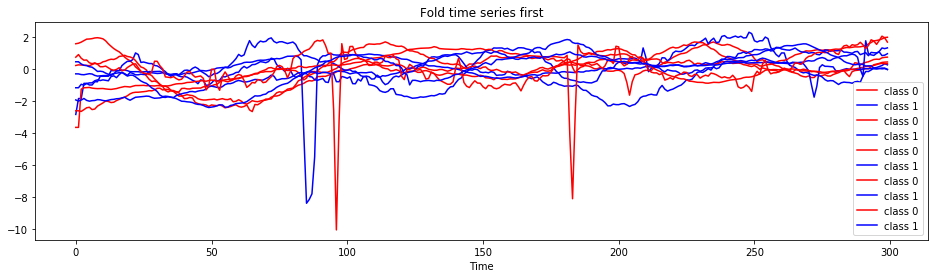

Dummy score:  0.49411764705882355
random forest score:  0.5411764705882353

0. xtrain (337, 1)
1. ytrain
 (337,)

fold:  2
['0' '1'] [169 168]
displaying first {n_display} samples for each class


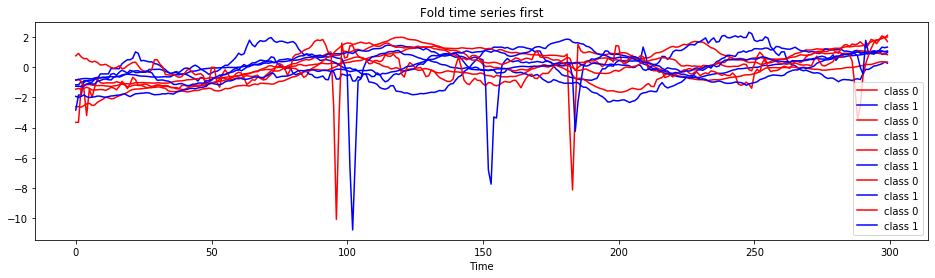

Dummy score:  0.49411764705882355
random forest score:  0.5764705882352941

0. xtrain (337, 1)
1. ytrain
 (337,)

fold:  3
['0' '1'] [169 169]
displaying first {n_display} samples for each class


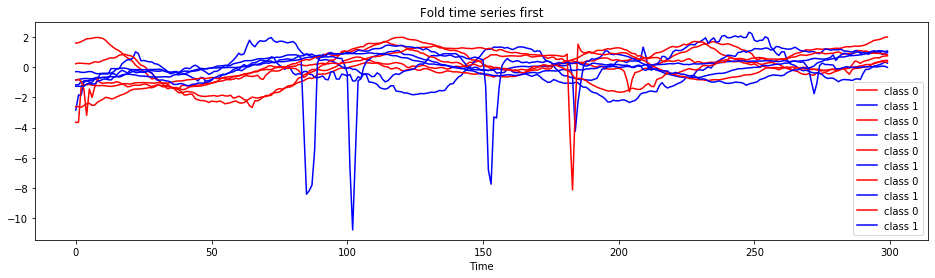

Dummy score:  0.5
random forest score:  0.6071428571428571

0. xtrain (338, 1)
1. ytrain
 (338,)

fold:  4
['0' '1'] [169 169]
displaying first {n_display} samples for each class


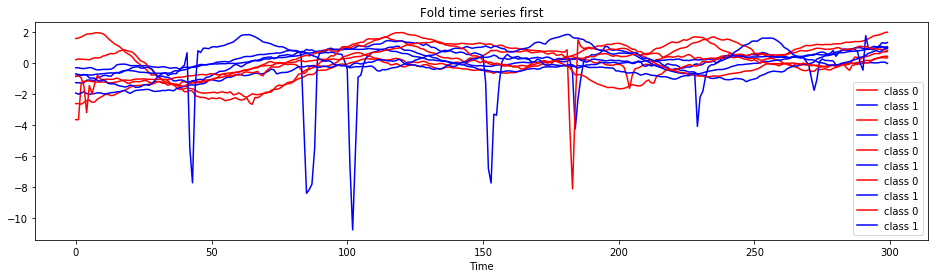

Dummy score:  0.5
random forest score:  0.5952380952380952

0. xtrain (338, 1)
1. ytrain
 (338,)

fold:  5
['0' '1'] [169 169]
displaying first {n_display} samples for each class


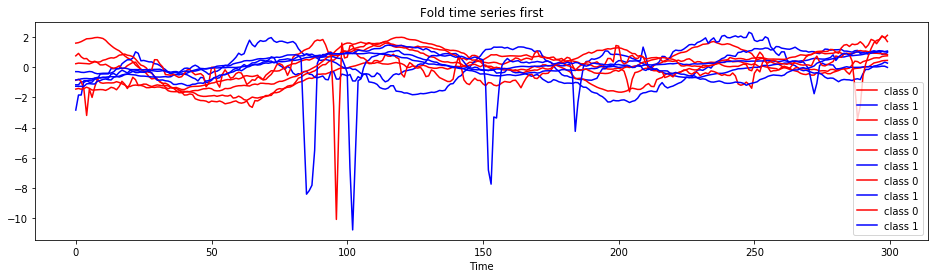

Dummy score:  0.5
random forest score:  0.5119047619047619

0. xtrain (338, 1)
1. ytrain
 (338,)

best acc:  0.61

_____________________________________________________________________

fold:  1
['0' '1'] [168 169]
displaying first {n_display} samples for each class


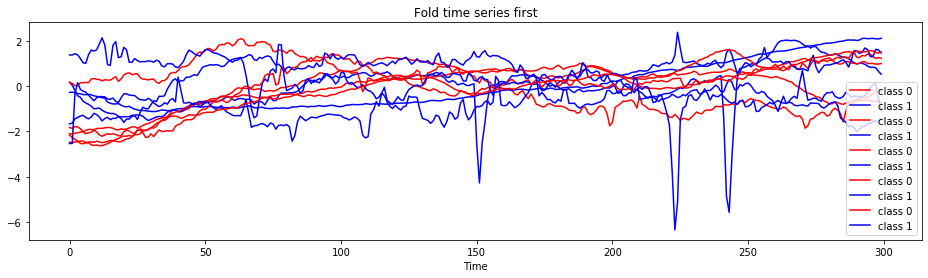

Dummy score:  0.49411764705882355
random forest score:  0.43529411764705883

0. xtrain (337, 1)
1. ytrain
 (337,)

fold:  2
['0' '1'] [169 168]
displaying first {n_display} samples for each class


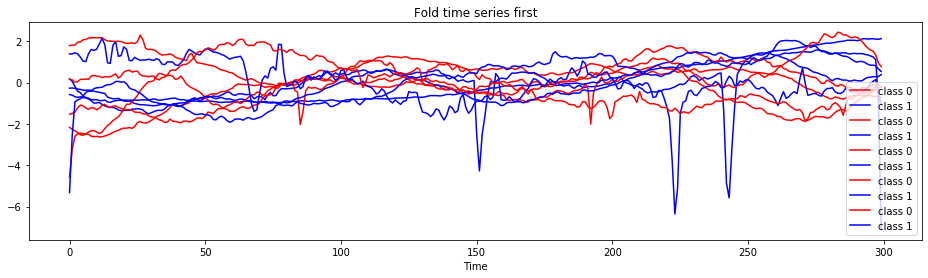

Dummy score:  0.49411764705882355
random forest score:  0.611764705882353

0. xtrain (337, 1)
1. ytrain
 (337,)

fold:  3
['0' '1'] [169 169]
displaying first {n_display} samples for each class


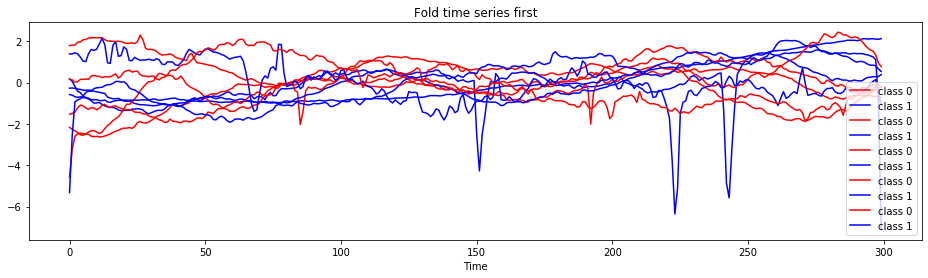

Dummy score:  0.5
random forest score:  0.5595238095238095

0. xtrain (338, 1)
1. ytrain
 (338,)

fold:  4
['0' '1'] [169 169]
displaying first {n_display} samples for each class


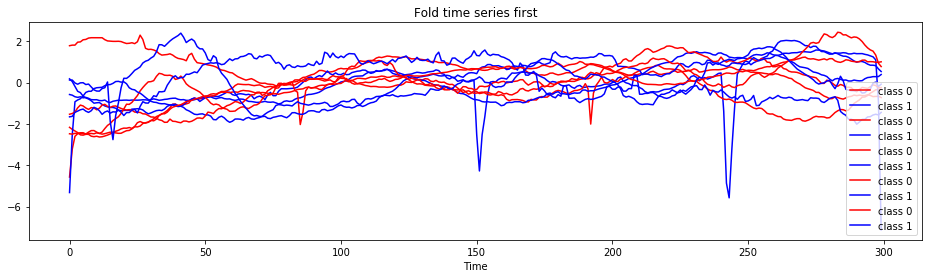

Dummy score:  0.5
random forest score:  0.5357142857142857

0. xtrain (338, 1)
1. ytrain
 (338,)

fold:  5
['0' '1'] [169 169]
displaying first {n_display} samples for each class


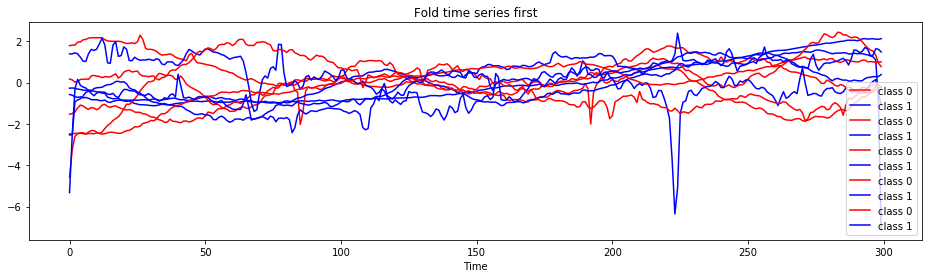

Dummy score:  0.5
random forest score:  0.5952380952380952

0. xtrain (338, 1)
1. ytrain
 (338,)

best acc:  0.61

_____________________________________________________________________

fold:  1
['0' '1'] [168 169]
displaying first {n_display} samples for each class


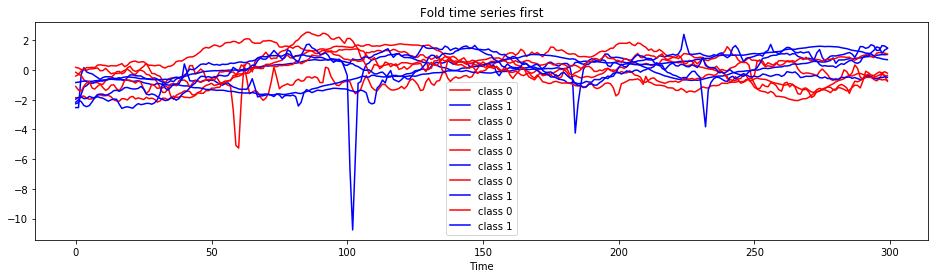

Dummy score:  0.49411764705882355
random forest score:  0.5411764705882353

0. xtrain (337, 1)
1. ytrain
 (337,)

fold:  2
['0' '1'] [169 168]
displaying first {n_display} samples for each class


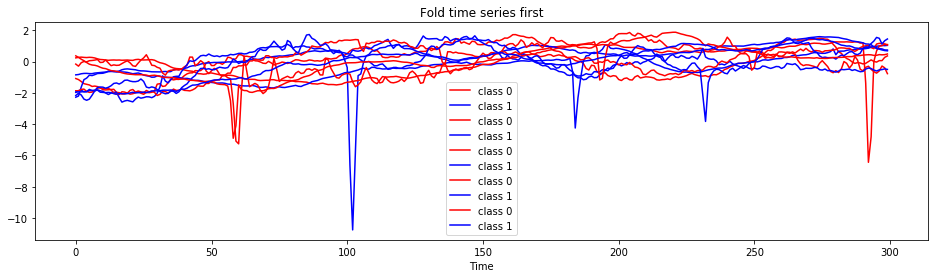

Dummy score:  0.49411764705882355
random forest score:  0.6235294117647059

0. xtrain (337, 1)
1. ytrain
 (337,)

fold:  3
['0' '1'] [169 169]
displaying first {n_display} samples for each class


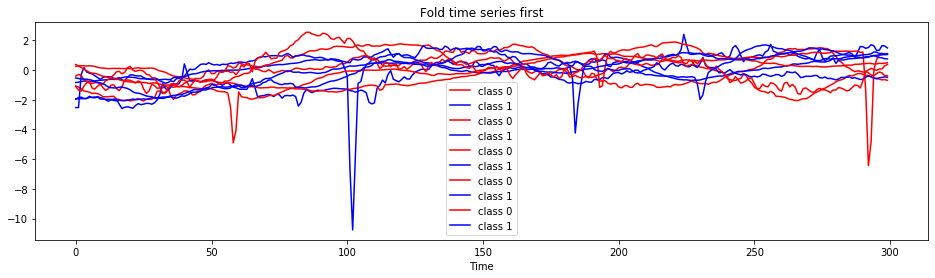

Dummy score:  0.5
random forest score:  0.5595238095238095

0. xtrain (338, 1)
1. ytrain
 (338,)

fold:  4
['0' '1'] [169 169]
displaying first {n_display} samples for each class


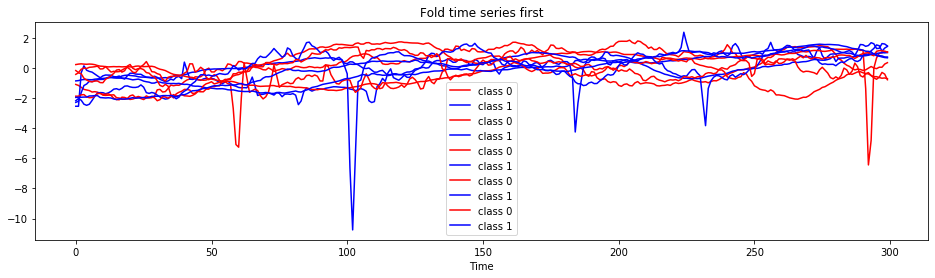

Dummy score:  0.5
random forest score:  0.5

0. xtrain (338, 1)
1. ytrain
 (338,)

fold:  5
['0' '1'] [169 169]
displaying first {n_display} samples for each class


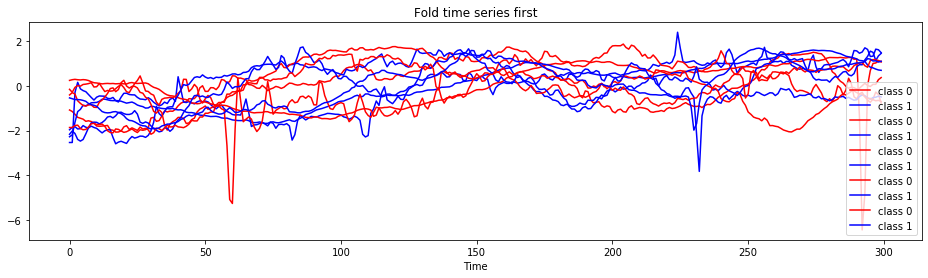

Dummy score:  0.5
random forest score:  0.5476190476190477

0. xtrain (338, 1)
1. ytrain
 (338,)

best acc:  0.62

_____________________________________________________________________

fold:  1
['0' '1'] [168 169]
displaying first {n_display} samples for each class


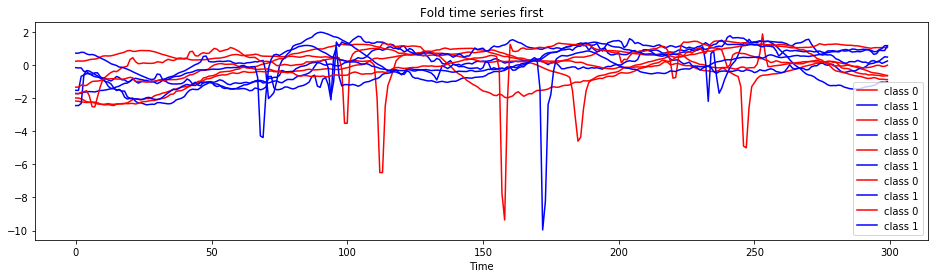

Dummy score:  0.49411764705882355
random forest score:  0.4823529411764706

0. xtrain (337, 1)
1. ytrain
 (337,)

fold:  2
['0' '1'] [169 168]
displaying first {n_display} samples for each class


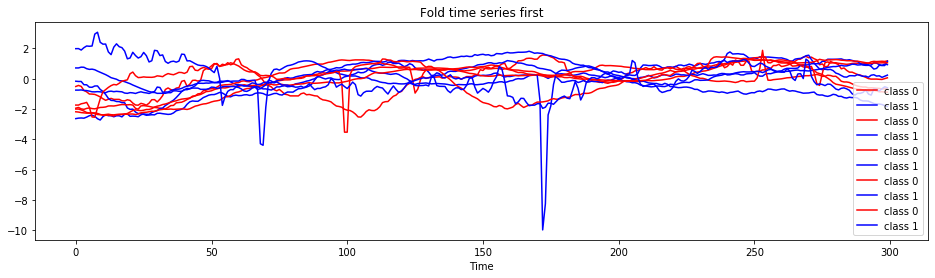

Dummy score:  0.49411764705882355
random forest score:  0.5411764705882353

0. xtrain (337, 1)
1. ytrain
 (337,)

fold:  3
['0' '1'] [169 169]
displaying first {n_display} samples for each class


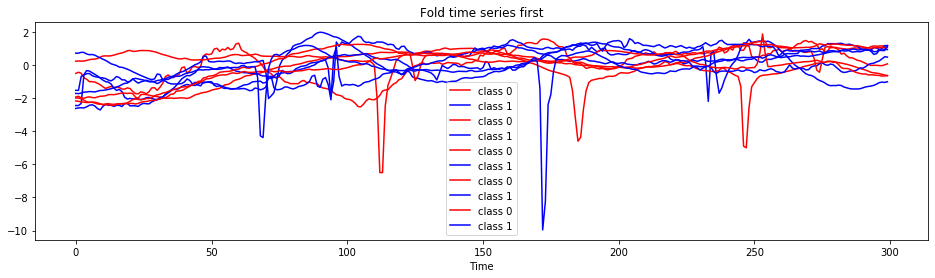

Dummy score:  0.5
random forest score:  0.6309523809523809

0. xtrain (338, 1)
1. ytrain
 (338,)

fold:  4
['0' '1'] [169 169]
displaying first {n_display} samples for each class


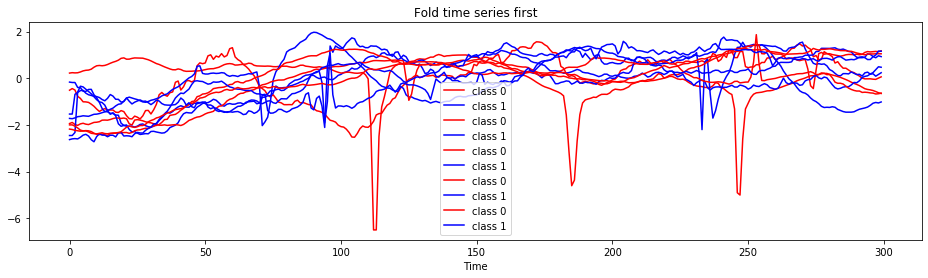

Dummy score:  0.5
random forest score:  0.5357142857142857

0. xtrain (338, 1)
1. ytrain
 (338,)

fold:  5
['0' '1'] [169 169]
displaying first {n_display} samples for each class


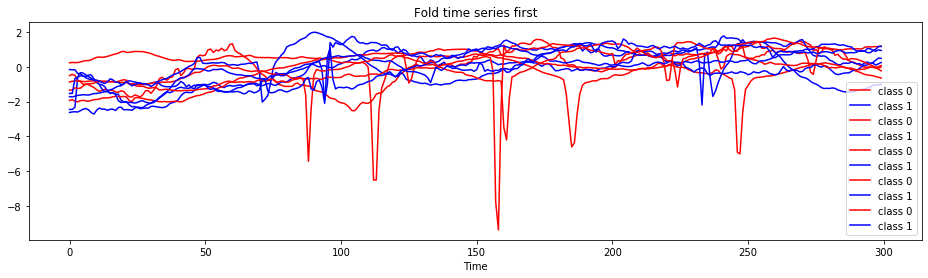

Dummy score:  0.5
random forest score:  0.5595238095238095

0. xtrain (338, 1)
1. ytrain
 (338,)

best acc:  0.63

best global acc:  0.63
              precision    recall  f1-score   support

           0       0.61      0.71      0.66        42
           1       0.66      0.55      0.60        42

    accuracy                           0.63        84
   macro avg       0.63      0.63      0.63        84
weighted avg       0.63      0.63      0.63        84


TABULARIZATION DATAFRAME SAMPLE: 

     pupil_dilation__0  pupil_dilation__1  pupil_dilation__2  \
21             -0.5113            -0.4406            -0.5048   
161             0.2236             0.2404             0.2307   
101            -1.9398            -1.8929            -1.9861   
292            -1.3425            -1.3396            -1.2164   
376            -0.8827            -0.8359            -0.8313   

     pupil_dilation__3  pupil_dilation__4  pupil_dilation__5  \
21             -0.7729            -0.8628         

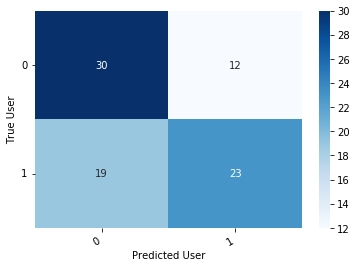

In [14]:
# 1. ...

import sys
from warnings import simplefilter
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
from sklearn.ensemble import RandomForestClassifier
from sktime.datatypes._panel._convert import from_nested_to_2d_array
# let's get a baseline for comparison
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score


simplefilter(action='ignore', category=FutureWarning)


seeds = [42, 1, 999, 4276, 67534]
n_samples = min(df_alt.rating.value_counts())

print("number of samples per class: ", n_samples)
print("\ntuning model...")
print("(data is shuffled)")

best_global_acc = 0
best_model = pd.DataFrame()

for seed in seeds:

  df_sample = df_alt.groupby('rating', group_keys=False).apply(lambda x: x.sample(n_samples, random_state=seed))
  # df_sample.participant_name.value_counts()

  y = df_sample['rating']
  X = df_sample
  del X['rating']

  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

  print("\n_____________________________________________________________________")

  best_acc = 0
  best_df_eval = pd.DataFrame()

  for ix, (train_index, test_index) in enumerate(skf.split(X, y), start=1):
    print("\nfold: ", ix)
    X_train, X_test = X.take(train_index), X.take(test_index)
    y_train, y_test = y.take(train_index), y.take(test_index)

    labels, counts = np.unique(y_train, return_counts=True)
    print(labels, counts)

    n_display = 5
    print("displaying first {n_display} samples for each class")
    fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))

    for i in range(n_display):
      for label in labels:
          X_train.loc[y_train == label, "pupil_dilation"].iloc[i].plot(ax=ax, label=f"class {label}", color='r' if label=="0" else 'b')
    plt.legend()
    ax.set(title="Fold time series first", xlabel="Time");
    plt.show()

    # X_train = X_train.applymap(lambda s: pd.Series(s))
    # X_test = X_test.applymap(lambda s: pd.Series(s))

    # TABULARIZATION
    X_train_tab = from_nested_to_2d_array(X_train)
    X_test_tab = from_nested_to_2d_array(X_test)

    # print("tabularization: ", X_train_tab.head())

    classifier = DummyClassifier(strategy="prior")
    classifier.fit(X_train_tab, y_train)
    print("Dummy score: ", classifier.score(X_test_tab, y_test))

    # now we can apply any scikit-learn classifier
    classifier = RandomForestClassifier(n_estimators=100)
    classifier.fit(X_train_tab, y_train)
    y_pred = classifier.predict(X_test_tab)
    print("random forest score: ", accuracy_score(y_test, y_pred))

    # display(X_train)
    print("\n0. xtrain", X_train.shape)
    print("1. ytrain\n", y_train.shape)

    # metrics
    predictions = classifier.predict(X_test_tab)

    df_eval = pd.DataFrame([(p, t) for p, t in zip(predictions, y_test.tolist())], columns=["prediction", "truth"])

    if best_acc < classifier.score(X_test_tab, y_test):
      best_acc = classifier.score(X_test_tab, y_test)
      best_df_eval = df_eval

  print("\nbest acc: ", round(best_acc, 2))
  if best_acc > best_global_acc:
    best_global_acc = best_acc
    best_model = best_df_eval

print("\nbest global acc: ", round(best_global_acc, 2))
print(classification_report(best_model.truth.tolist(), best_model.prediction.tolist(), target_names=list(set(best_model.truth.tolist()))))

cm = confusion_matrix(best_model.truth.tolist(), best_model.prediction.tolist())
df_cm = pd.DataFrame(cm, index=list(set(best_model.truth.tolist())), columns=list(set(best_model.truth.tolist())))

print("\nTABULARIZATION DATAFRAME SAMPLE: \n")
print(X_train_tab.head())

show_confusion_matrix(df_cm)
plt.show()

#### Extracting Statistical Features

In [60]:
# 2. # extract features from the univariate

feature_transformer = TSFreshFeatureExtractor(default_fc_parameters="minimal")
extracted_features = feature_transformer.fit_transform(X)
print(extracted_features.describe())
extracted_features.shape
# extracted_features

df_extrated_features = pd.concat([extracted_features, y], axis=1)
df_extrated_features

Feature Extraction: 100%|██████████| 480/480 [00:00<00:00, 976.33it/s] 


       pupil_dilation__sum_values  pupil_dilation__median  \
count                4.800000e+02              480.000000   
mean                -4.791667e-06                0.081449   
std                  4.619532e-04                0.190705   
min                 -1.200000e-03               -0.457350   
25%                 -3.000000e-04               -0.047825   
50%                 -1.776357e-15                0.089900   
75%                  3.000000e-04                0.225175   
max                  1.400000e-03                0.577500   

       pupil_dilation__mean  pupil_dilation__length  \
count          4.800000e+02                   480.0   
mean          -1.597222e-08                   300.0   
std            1.539844e-06                     0.0   
min           -4.000000e-06                   300.0   
25%           -1.000000e-06                   300.0   
50%           -5.921189e-18                   300.0   
75%            1.000000e-06                   300.0   
max       

,pupil_dilation__sum_values,pupil_dilation__median,pupil_dilation__mean,pupil_dilation__length,pupil_dilation__standard_deviation,pupil_dilation__variance,pupil_dilation__root_mean_square,pupil_dilation__maximum,pupil_dilation__absolute_maximum,pupil_dilation__minimum,rating
0,0.0005,0.28450,1.666667e-06,300.0,1.000000,0.999999,1.000000,0.9287,9.5820,-9.5820,1
1,-0.0003,0.14180,-1.000000e-06,300.0,1.000001,1.000002,1.000001,1.8673,2.3996,-2.3996,1
2,-0.0003,0.03795,-1.000000e-06,300.0,1.000001,1.000001,1.000001,2.1415,2.1415,-1.8781,1
3,-0.0003,0.05580,-1.000000e-06,300.0,1.000000,1.000000,1.000000,1.7269,2.0880,-2.0880,0
4,-0.0002,0.29510,-6.666667e-07,300.0,0.999999,0.999997,0.999999,1.2031,2.7246,-2.7246,1
...,...,...,...,...,...,...,...,...,...,...,...
475,-0.0005,0.39270,-1.666667e-06,300.0,1.000002,1.000003,1.000002,1.9028,3.2445,-3.2445,0
476,0.0003,0.45080,1.000000e-06,300.0,1.000001,1.000003,1.000001,0.9828,9.0993,-9.0993,0
477,0.0005,0.08390,1.666667e-06,300.0,0.999998,0.999996,0.999998,1.9775,7.6903,-7.6903,0
478,0.0007,-0.02370,2.333333e-06,300.0,1.000001,1.000002,1.000001,2.3507,2.3507,-2.3127,0


number of samples per class:  211

tuning model...
(data is shuffled)

_____________________________________________________________________

fold:  1

0. xtrain (337, 10)
1. ytrain
 (337,)
Dummy score:  0.49411764705882355
random forest score:  0.611764705882353

0. xtrain (337, 10)
1. ytrain
 (337,)

fold:  2

0. xtrain (337, 10)
1. ytrain
 (337,)
Dummy score:  0.49411764705882355
random forest score:  0.4235294117647059

0. xtrain (337, 10)
1. ytrain
 (337,)

fold:  3

0. xtrain (338, 10)
1. ytrain
 (338,)
Dummy score:  0.5
random forest score:  0.5119047619047619

0. xtrain (338, 10)
1. ytrain
 (338,)

fold:  4

0. xtrain (338, 10)
1. ytrain
 (338,)
Dummy score:  0.5
random forest score:  0.4642857142857143

0. xtrain (338, 10)
1. ytrain
 (338,)

fold:  5

0. xtrain (338, 10)
1. ytrain
 (338,)
Dummy score:  0.5
random forest score:  0.4642857142857143

0. xtrain (338, 10)
1. ytrain
 (338,)

best acc:  0.61

_____________________________________________________________________

fold

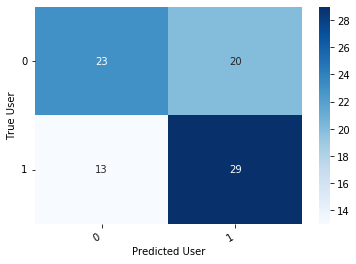

In [61]:
# RandomForestClassifier()
# )
# classifier.fit(X_train, y_train)
# classifier.score(X_test, y_test)

# 2. With the extracted features

# todo: X is being replaced everytime so I need run Data and Pre-processing again

import sys
from warnings import simplefilter
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor


simplefilter(action='ignore', category=FutureWarning)


seeds = [42, 1, 999, 4276, 67534]
n_samples = min(df_alt.rating.value_counts())

print("number of samples per class: ", n_samples)
print("\ntuning model...")
print("(data is shuffled)")

best_global_acc = 0
best_model = pd.DataFrame()

for seed in seeds:

  df_sample = df_extrated_features.groupby('rating', group_keys=False).apply(lambda x: x.sample(n_samples, random_state=seed))
  # df_sample.participant_name.value_counts()

  y = df_sample['rating']
  X = df_sample
  del X['rating']


  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

  print("\n_____________________________________________________________________")

  best_acc = 0
  best_df_eval = pd.DataFrame()

  for ix, (train_index, test_index) in enumerate(skf.split(X, y), start=1):
    print("\nfold: ", ix)
    X_train, X_test = X.take(train_index), X.take(test_index)
    y_train, y_test = y.take(train_index), y.take(test_index)

    # X_train = X_train.applymap(lambda s: pd.Series(s))
    # X_test = X_test.applymap(lambda s: pd.Series(s))

    # display(X_train)
    print("\n0. xtrain", X_train.shape)
    print("1. ytrain\n", y_train.shape)

    classifier = DummyClassifier(strategy="prior")
    classifier.fit(X_train, y_train)
    print("Dummy score: ", classifier.score(X_test, y_test))

    # now we can apply any scikit-learn classifier
    classifier = RandomForestClassifier(n_estimators=100)

    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    print("random forest score: ", accuracy_score(y_test, y_pred))

    # display(X_train)
    print("\n0. xtrain", X_train.shape)
    print("1. ytrain\n", y_train.shape)

    # metrics
    predictions = classifier.predict(X_test)

    df_eval = pd.DataFrame([(p, t) for p, t in zip(predictions, y_test.tolist())], columns=["prediction", "truth"])

    if best_acc < classifier.score(X_test, y_test):
      best_acc = classifier.score(X_test, y_test)
      best_df_eval = df_eval

  print("\nbest acc: ", round(best_acc, 2))
  if best_acc > best_global_acc:
    best_global_acc = best_acc
    best_model = best_df_eval

print("\nbest global acc: ", round(best_global_acc, 2))
print(classification_report(best_model.truth.tolist(), best_model.prediction.tolist(), target_names=list(set(best_model.truth.tolist()))))

cm = confusion_matrix(best_model.truth.tolist(), best_model.prediction.tolist())
df_cm = pd.DataFrame(cm, index=list(set(best_model.truth.tolist())), columns=list(set(best_model.truth.tolist())))

show_confusion_matrix(df_cm)
plt.show()

#### Rocket Univariate

In [62]:
df_alt

,pupil_dilation,rating
0,0 -0.9014 1 -0.8590 2 -0.8329 3 ...,1
1,0 -1.2559 1 -1.0630 2 -1.0623 3 ...,1
2,0 -0.4935 1 -0.6439 2 -0.7684 3 ...,1
3,0 -1.0812 1 -1.1477 2 -1.2715 3 ...,0
4,0 -2.5562 1 -2.6070 2 -2.6038 3 ...,1
...,...,...
475,0 -0.4229 1 -0.3993 2 -0.4078 3 ...,0
476,0 -0.9680 1 -0.9316 2 -0.9057 3 ...,0
477,0 -1.0654 1 -1.0005 2 -0.9954 3 ...,0
478,0 -0.3034 1 -0.2804 2 -0.2725 3 ...,0


number of samples per class:  211

tuning model...
(data is shuffled)

_____________________________________________________________________

fold:  1

0. xtrain (337, 1)
1. ytrain
 (337,)

2. xtrain-transform
 (337, 9996)
accuracy:  0.5529411764705883

fold:  2

0. xtrain (337, 1)
1. ytrain
 (337,)

2. xtrain-transform
 (337, 9996)
accuracy:  0.5882352941176471

fold:  3

0. xtrain (338, 1)
1. ytrain
 (338,)

2. xtrain-transform
 (338, 9996)
accuracy:  0.4523809523809524

fold:  4

0. xtrain (338, 1)
1. ytrain
 (338,)

2. xtrain-transform
 (338, 9996)
accuracy:  0.5238095238095238

fold:  5

0. xtrain (338, 1)
1. ytrain
 (338,)

2. xtrain-transform
 (338, 9996)
accuracy:  0.4642857142857143

best acc:  0.59

_____________________________________________________________________

fold:  1

0. xtrain (337, 1)
1. ytrain
 (337,)

2. xtrain-transform
 (337, 9996)
accuracy:  0.5058823529411764

fold:  2

0. xtrain (337, 1)
1. ytrain
 (337,)

2. xtrain-transform
 (337, 9996)
accuracy:  0.4823

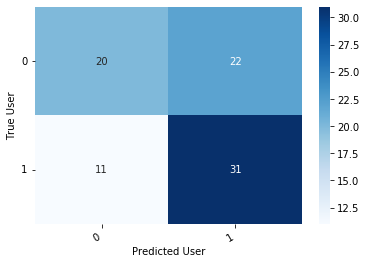

In [63]:
# 3. running univariate: Rocket

import sys
from warnings import simplefilter
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor


simplefilter(action='ignore', category=FutureWarning)


seeds = [42, 1, 999, 4276, 67534]
n_samples = min(df_alt.rating.value_counts())

print("number of samples per class: ", n_samples)
print("\ntuning model...")
print("(data is shuffled)")

best_global_acc = 0
best_model = pd.DataFrame()

for seed in seeds:

  df_sample = df_alt.groupby('rating', group_keys=False).apply(lambda x: x.sample(n_samples, random_state=seed))
  # df_sample.participant_name.value_counts()

  y = df_sample['rating']
  X = df_sample
  del X['rating']

  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

  print("\n_____________________________________________________________________")

  best_acc = 0
  best_df_eval = pd.DataFrame()

  for ix, (train_index, test_index) in enumerate(skf.split(X, y), start=1):
    print("\nfold: ", ix)
    X_train, X_test = X.take(train_index), X.take(test_index)
    y_train, y_test = y.take(train_index), y.take(test_index)

    # X_train = X_train.applymap(lambda s: pd.Series(s))
    # X_test = X_test.applymap(lambda s: pd.Series(s))

    # display(X_train)
    print("\n0. xtrain", X_train.shape)
    print("1. ytrain\n", y_train.shape)

    # print("training classifier...")
    minirocket = MiniRocket()  # MiniRocket() # for univariate; MiniRocketMultivariate; time series transformation
    minirocket.fit(X_train)
    X_train_transform = minirocket.transform(X_train)

    print("\n2. xtrain-transform\n", X_train_transform.shape)

    classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)

    classifier.fit(X_train_transform, y_train)

    X_test_transform = minirocket.transform(X_test)

    print("accuracy: ", classifier.score(X_test_transform, y_test))

    predictions = classifier.predict(X_test_transform)

    df_eval = pd.DataFrame([(p, t) for p, t in zip(predictions, y_test.tolist())], columns=["prediction", "truth"])

    if best_acc < classifier.score(X_test_transform, y_test):
      best_acc = classifier.score(X_test_transform, y_test)
      best_df_eval = df_eval

  print("\nbest acc: ", round(best_acc, 2))
  if best_acc > best_global_acc:
    best_global_acc = best_acc
    best_model = best_df_eval

print("\nbest global acc: ", round(best_global_acc, 2))
print(classification_report(best_model.truth.tolist(), best_model.prediction.tolist(), target_names=list(set(best_model.truth.tolist()))))

cm = confusion_matrix(best_model.truth.tolist(), best_model.prediction.tolist())
df_cm = pd.DataFrame(cm, index=list(set(best_model.truth.tolist())), columns=list(set(best_model.truth.tolist())))

show_confusion_matrix(df_cm)
plt.show()

### Backup

In [ ]:
X_concat = pd.concat([X, extracted_features], axis=1)
X_concat

In [ ]:
for col in X_concat.columns:
  print()
  print(X_concat[col].dtype)
  print(X_concat[col].shape)
print()
print(y['rating'].dtype)
print(y.shape)
print(X.shape)

In [ ]:
# fix to df_alt
df_alt = pd.concat([X_concat, y], axis=1)
df_alt  # with objects and floats....
# df_alt.to_csv("df_feature_extraction.csv")

In [ ]:
# !pip install sktime[all_extras] --quiet

In [ ]:
# 1. ...

import sys
from warnings import simplefilter
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor


simplefilter(action='ignore', category=FutureWarning)


seeds = [42, 1, 999, 4276, 67534]
n_samples = min(df_alt.rating.value_counts())

print("number of samples per class: ", n_samples)
print("\ntuning model...")
print("(data is shuffled)")

best_global_acc = 0
best_model = pd.DataFrame()

for seed in seeds:

  df_sample = df_alt.groupby('rating', group_keys=False).apply(lambda x: x.sample(n_samples, random_state=seed))
  # df_sample.participant_name.value_counts()

  y = df_sample['rating']
  X = df_sample
  del X['rating']

  print("AFTER SAMPLING: ")
  for col in X.columns:
    print()
    print(X[col].dtype)
    print(X[col].shape)
  print()
  print(y.dtype)
  print(y.shape)
  print(X.shape)

  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

  print("\n_____________________________________________________________________")

  best_acc = 0
  best_df_eval = pd.DataFrame()

  for ix, (train_index, test_index) in enumerate(skf.split(X, y), start=1):
    print("\nfold: ", ix)
    X_train, X_test = X.take(train_index), X.take(test_index)
    y_train, y_test = y.take(train_index), y.take(test_index)

    print("AFTER FOLD: ")
    for col in X_train.columns:
      print()
      print(X_train[col].dtype)
      print(X_train[col].shape)
    print()
    print(y_train['rating'].dtype)
    print(y_train.shape)
    print(X_train.shape)

    X_train = X_train.applymap(lambda s: pd.Series(s))
    X_test = X_test.applymap(lambda s: pd.Series(s))

    print("AFTER MAP: ")
    for col in X_train.columns:
      print()
      print(X_train[col].dtype)
      print(X_train[col].shape)
    print()
    print(y_train['rating'].dtype)
    print(y_train.shape)
    print(X_train.shape)

    # display(X_train)
    print("\n0. xtrain", X_train.shape)
    print("1. ytrain\n", y_train.shape)

    # print("training classifier...")
    minirocket_multi = MiniRocketMultivariate()  # MiniRocket() # for univariate; MiniRocketMultivariate; time series transformation
    minirocket_multi.fit(X_train)
    X_train_transform = minirocket_multi.transform(X_train)

    print("\n2. xtrain-transform\n", X_train_transform.shape)

    classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)

    classifier.fit(X_train_transform, y_train)

    X_test_transform = minirocket_multi.transform(X_test)

    print("accuracy: ", classifier.score(X_test_transform, y_test))

    predictions = classifier.predict(X_test_transform)

    df_eval = pd.DataFrame([(p, t) for p, t in zip(predictions, y_test.tolist())], columns=["prediction", "truth"])

    if best_acc < classifier.score(X_test_transform, y_test):
      best_acc = classifier.score(X_test_transform, y_test)
      best_df_eval = df_eval

  print("\nbest acc: ", round(best_acc, 2))
  if best_acc > best_global_acc:
    best_global_acc = best_acc
    best_model = best_df_eval

print("\nbest global acc: ", round(best_global_acc, 2))
print(classification_report(best_model.truth.tolist(), best_model.prediction.tolist(), target_names=list(set(best_model.truth.tolist()))))

cm = confusion_matrix(best_model.truth.tolist(), best_model.prediction.tolist())
df_cm = pd.DataFrame(cm, index=list(set(best_model.truth.tolist())), columns=list(set(best_model.truth.tolist())))

show_confusion_matrix(df_cm)
plt.show()

In [ ]:
# no norm and default alphas

from warnings import simplefilter


simplefilter(action='ignore', category=FutureWarning)


seeds = [42, 1, 999, 4276, 67534]
n_samples = min(df.participant_name.value_counts())

print("number of samples per class: ", n_samples)
print("\ntuning model...")
print("(data is shuffled)")

best_global_acc = 0
best_model = pd.DataFrame()

for seed in seeds:

  df_sample = df.groupby('participant_name', group_keys=False).apply(lambda x: x.sample(n_samples, random_state=seed))
  df_sample.participant_name.value_counts()

  y = df_sample['participant_name']
  X = df_sample
  del X['participant_name']

  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

  print("\n_____________________________________________________________________")

  best_acc = 0
  best_df_eval = pd.DataFrame()

  for ix, (train_index, test_index) in enumerate(skf.split(X, y), start=1):
    print("\nfold: ", ix)
    X_train, X_test = X.take(train_index), X.take(test_index)
    y_train, y_test = y.take(train_index), y.take(test_index)

    del X_train['pattern_name']
    del X_train['speed']
    del X_train['series_original_lenght']

    del X_test['pattern_name']
    del X_test['speed']
    del X_test['series_original_lenght']

    X_train = X_train.applymap(lambda s: pd.Series(s))
    X_test = X_test.applymap(lambda s: pd.Series(s))

    # print("training classifier...")
    minirocket_multi = MiniRocketMultivariate()
    minirocket_multi.fit(X_train)
    X_train_transform = minirocket_multi.transform(X_train)

    classifier = RidgeClassifierCV(normalize=False)
    classifier.fit(X_train_transform, y_train)

    X_test_transform = minirocket_multi.transform(X_test)

    print("accuracy: ", classifier.score(X_test_transform, y_test))

    predictions = classifier.predict(X_test_transform)

    df_eval = pd.DataFrame([(p, t) for p, t in zip(predictions, y_test.tolist())], columns=["prediction", "truth"])

    if best_acc < classifier.score(X_test_transform, y_test):
      best_acc = classifier.score(X_test_transform, y_test)
      best_df_eval = df_eval

  print("\nbest acc: ", round(best_acc, 2))
  if best_acc > best_global_acc:
    best_global_acc = best_acc
    best_model = best_df_eval

print("\nbest global acc: ", round(best_global_acc, 2))
print(classification_report(best_model.truth.tolist(), best_model.prediction.tolist(), target_names=list(set(best_model.truth.tolist()))))

cm = confusion_matrix(best_model.truth.tolist(), best_model.prediction.tolist())
df_cm = pd.DataFrame(cm, index=list(set(best_model.truth.tolist())), columns=list(set(best_model.truth.tolist())))

show_confusion_matrix(df_cm)
plt.show()

number of samples per class:  82

tuning model...
(data is shuffled)

_____________________________________________________________________

fold:  1
accuracy:  0.8260869565217391

fold:  2
accuracy:  0.8347826086956521

fold:  3
accuracy:  0.8521739130434782

fold:  4
accuracy:  0.8608695652173913

fold:  5
accuracy:  0.8771929824561403

best acc:  0.88

_____________________________________________________________________

fold:  1
